In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread # Para cargar imágenes
from skimage.transform import resize # Para redimensionar
from skimage.feature import hog # Para extraer características HOG
from sklearn.model_selection import train_test_split # Para dividir datos
from sklearn.svm import SVC # Máquina de Vectores de Soporte (SVM) como ejemplo de clasificador
from sklearn.ensemble import RandomForestClassifier # Opcional: Random Forest
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler # Para escalado de características
import joblib
import seaborn as sns
from tqdm import tqdm # Para barras de progreso

In [22]:
#Configuración de Rutas
CURRENT_NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.dirname(CURRENT_NOTEBOOK_DIR)
BASE_DATA_PATH = os.path.join(PROJECT_ROOT, "data")
BASE_IMAGES_PATH = os.path.join(PROJECT_ROOT, "data", "imagenes_gladiadores")

#Rutas a los directorios de entrenamiento y prueba
TRAIN_DIR = os.path.join(BASE_IMAGES_PATH, "train")
TEST_DIR = os.path.join(BASE_IMAGES_PATH, "test")
#predict
PREDICT_DIR = os.path.join(BASE_DATA_PATH, "predict")

print(f"Directorio actual del Notebook: {CURRENT_NOTEBOOK_DIR}")
print(f"Ruta raíz del proyecto: {PROJECT_ROOT}")
print(f"Directorio base de imágenes: {BASE_IMAGES_PATH}")
print(f"Directorio de entrenamiento: {TRAIN_DIR}")
print(f"Directorio de prueba: {TEST_DIR}")


#Parámetros para las Imágenes y Extracción de Características 
IMG_HEIGHT = 128 # Altura a la que redimensionaremos las imágenes
IMG_WIDTH = 128  # Ancho a la que redimensionaremos las imágenes

#Parámetros HOG (Histograma de Gradientes Orientados)
PIXELS_PER_CELL = (8, 8) # Tamaño de la celda en píxeles (ej. 8x8)
CELLS_PER_BLOCK = (2, 2) # Número de celdas por bloque (ej. 2x2)
ORIENTATIONS = 9         # Número de bins de orientación (ej. 9)

#Mapeo de nombres de carpetas a etiquetas numéricas (clases)
CLASS_LABELS = {'gladiadores': 0, 'no_gladiadores': 1}
# El orden aquí es importante: 'gladiadores' -> 0, 'no_gladiadores' -> 1

Directorio actual del Notebook: c:\Users\yoai\Documents\REPO_GLADIADORES_ML\REPO_GLADIADORES_ML\notebooks
Ruta raíz del proyecto: c:\Users\yoai\Documents\REPO_GLADIADORES_ML\REPO_GLADIADORES_ML
Directorio base de imágenes: c:\Users\yoai\Documents\REPO_GLADIADORES_ML\REPO_GLADIADORES_ML\data\imagenes_gladiadores
Directorio de entrenamiento: c:\Users\yoai\Documents\REPO_GLADIADORES_ML\REPO_GLADIADORES_ML\data\imagenes_gladiadores\train
Directorio de prueba: c:\Users\yoai\Documents\REPO_GLADIADORES_ML\REPO_GLADIADORES_ML\data\imagenes_gladiadores\test


In [3]:
def extract_features_from_directory(directory_path, label_id, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    """
    Carga imágenes de un directorio, las redimensiona, las convierte a escala de grises
    y extrae características HOG.

    Args:
        directory_path (str): La ruta al directorio que contiene las imágenes de una clase.
        label_id (int): La etiqueta numérica asociada a las imágenes de este directorio.
        target_size (tuple): La tupla (altura, ancho) a la que redimensionar las imágenes.

    Returns:
        tuple: Una tupla que contiene (np.array de características HOG, np.array de etiquetas, lista de rutas de imagen).
    """
    features_list = []
    labels_list = []
    image_paths = [] # Opcional: para depuración o referencia

    #Obtengo el nombre de la clase para los mensajes de progreso
    class_name = [name for name, id in CLASS_LABELS.items() if id == label_id][0]
    print(f"\nExtrayendo características para la clase '{class_name}' de: {directory_path}")

    #Listo todos los archivos en el directorio
    for img_name in tqdm(os.listdir(directory_path), desc=f"Procesando {class_name}"):
        img_path = os.path.join(directory_path, img_name)

        #Saltar si no es un archivo de imagen 
        if not os.path.isfile(img_path) or img_name.startswith('.'):
            continue
        if not (img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))):
            continue

        try:
            #Cargar imagen
            img = imread(img_path)

            #Redimensionar la imagen (necesario para HOG si no tienen el mismo tamaño)
            img_resized = resize(img, target_size, anti_aliasing=True)

            #Convertir a escala de grises si la imagen es a color
            #HOG generalmente funciona mejor en escala de grises
            if img_resized.ndim == 3: # Si es a color (tiene 3 dimensiones: H, W, Canales)
                img_resized = np.mean(img_resized, axis=2) # Simple promedio de canales para escala de grises

            #Extraer características HOG
            hog_features = hog(img_resized,
                               orientations=ORIENTATIONS,
                               pixels_per_cell=PIXELS_PER_CELL,
                               cells_per_block=CELLS_PER_BLOCK,
                               block_norm='L2-Hys', # Normalización del bloque (L2-Hys es común)
                               feature_vector=True) # Devuelve un vector plano de características

            features_list.append(hog_features)
            labels_list.append(label_id)
            image_paths.append(img_path)

        except Exception as e:
            print(f"Error procesando {img_path}: {e}")
            continue # Continúa con la siguiente imagen si hay un error

    return np.array(features_list), np.array(labels_list), image_paths

In [4]:
#Carga y Extracción de Características para el Conjunto de Entrenamiento 
print("--- Procesando datos de entrenamiento ---")
#Para la clase 'gladiadores' en entrenamiento
gladiadores_train_features, gladiadores_train_labels, _ = \
    extract_features_from_directory(os.path.join(TRAIN_DIR, 'gladiadores'), CLASS_LABELS['gladiadores'])

#Para la clase 'no_gladiadores' en entrenamiento
no_gladiadores_train_features, no_gladiadores_train_labels, _ = \
    extract_features_from_directory(os.path.join(TRAIN_DIR, 'no_gladiadores'), CLASS_LABELS['no_gladiadores'])

#Combinar todas las características y etiquetas de entrenamiento
X_train = np.vstack((gladiadores_train_features, no_gladiadores_train_features))
y_train = np.concatenate((gladiadores_train_labels, no_gladiadores_train_labels))

print(f"\nCaracterísticas de entrenamiento (X_train) shape: {X_train.shape}")
print(f"Etiquetas de entrenamiento (y_train) shape: {y_train.shape}")


#Carga y Extracción de Características para el Conjunto de Prueba
print("\n--- Procesando datos de prueba ---")
#Para la clase 'gladiadores' en prueba
gladiadores_test_features, gladiadores_test_labels, _ = \
    extract_features_from_directory(os.path.join(TEST_DIR, 'gladiadores'), CLASS_LABELS['gladiadores'])

#Para la clase 'no_gladiadores' en prueba
no_gladiadores_test_features, no_gladiadores_test_labels, _ = \
    extract_features_from_directory(os.path.join(TEST_DIR, 'no_gladiadores'), CLASS_LABELS['no_gladiadores'])

#Combinar todas las características y etiquetas de prueba
X_test = np.vstack((gladiadores_test_features, no_gladiadores_test_features))
y_test = np.concatenate((gladiadores_test_labels, no_gladiadores_test_labels))

print(f"\nCaracterísticas de prueba (X_test) shape: {X_test.shape}")
print(f"Etiquetas de prueba (y_test) shape: {y_test.shape}")

--- Procesando datos de entrenamiento ---

Extrayendo características para la clase 'gladiadores' de: c:\Users\yoai\Documents\REPO_GLADIADORES_ML\REPO_GLADIADORES_ML\data\imagenes_gladiadores\train\gladiadores


Procesando gladiadores: 100%|██████████| 864/864 [00:58<00:00, 14.71it/s]



Extrayendo características para la clase 'no_gladiadores' de: c:\Users\yoai\Documents\REPO_GLADIADORES_ML\REPO_GLADIADORES_ML\data\imagenes_gladiadores\train\no_gladiadores


Procesando no_gladiadores: 100%|██████████| 868/868 [00:43<00:00, 19.80it/s]



Características de entrenamiento (X_train) shape: (1730, 8100)
Etiquetas de entrenamiento (y_train) shape: (1730,)

--- Procesando datos de prueba ---

Extrayendo características para la clase 'gladiadores' de: c:\Users\yoai\Documents\REPO_GLADIADORES_ML\REPO_GLADIADORES_ML\data\imagenes_gladiadores\test\gladiadores


Procesando gladiadores: 100%|██████████| 156/156 [00:08<00:00, 18.87it/s]



Extrayendo características para la clase 'no_gladiadores' de: c:\Users\yoai\Documents\REPO_GLADIADORES_ML\REPO_GLADIADORES_ML\data\imagenes_gladiadores\test\no_gladiadores


Procesando no_gladiadores: 100%|██████████| 156/156 [00:06<00:00, 25.92it/s]


Características de prueba (X_test) shape: (312, 8100)
Etiquetas de prueba (y_test) shape: (312,)


In [9]:
#Escalar las características
# StandardScaler hace que la media sea 0 y la desviación estándar 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Ajusta el scaler y transforma los datos de entrenamiento
X_test_scaled = scaler.transform(X_test)       # Solo transforma los datos de prueba usando el scaler ajustado con entrenamiento

#Guardo el scaler también, ya que lo necesitarás para transformar nuevas imágenes antes de predecir
# Lo guardamos en la carpeta 'models' al mismo nivel que 'data'
scaler_save_path = os.path.join(PROJECT_ROOT, "models", "scaler_gladiador_rdf.pkl")
joblib.dump(scaler, scaler_save_path)
print(f"Scaler guardado en: {scaler_save_path}")

Scaler guardado en: c:\Users\yoai\Documents\REPO_GLADIADORES_ML\REPO_GLADIADORES_ML\models\scaler_gladiador_rdf.pkl


In [13]:
# Inicializar y entrenar el clasificador RandomForestClassifier
# n_estimators: Número de árboles en el bosque (más suele ser mejor, pero más lento)
# random_state: Para resultados reproducibles
# class_weight: Puede ser útil si las clases están desbalanceadas (aunque en tu caso, están balanceadas)
print("\nEntrenando el modelo de clasificación (RandomForestClassifier)...")
model_rfc = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
# 'balanced' ajusta automáticamente los pesos de las clases inversamente proporcionales a las frecuencias de las clases
# Esto puede ser útil incluso con clases balanceadas para dar un ligero énfasis.
model_rfc.fit(X_train_scaled, y_train) # Entrenar con los datos ESCALADOS
print("Entrenamiento completado.")


Entrenando el modelo de clasificación (RandomForestClassifier)...
Entrenamiento completado.



Precisión total en el conjunto de prueba: 54.17%

--- Matriz de Confusión ---


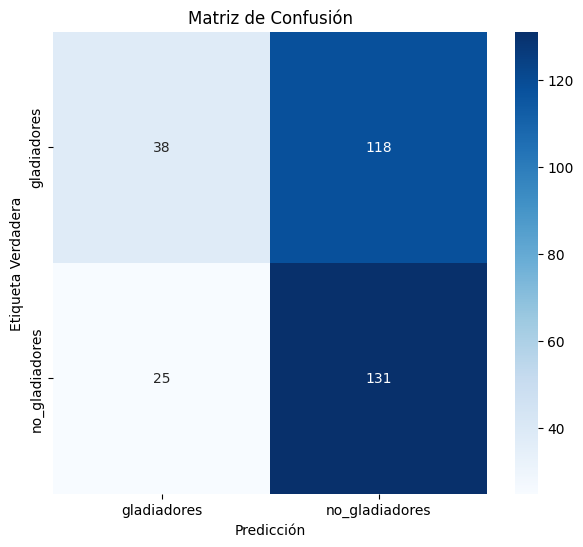

In [14]:
#Hago predicciones en el conjunto de prueba
y_pred = model_rfc.predict(X_test_scaled)

#Obtengo los nombres de las clases en el orden correcto (0 -> 'gladiadores', 1 -> 'no_gladiadores')
target_names = [name for name, _id in sorted(CLASS_LABELS.items(), key=lambda item: item[1])]

#Precisión general
accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrecisión total en el conjunto de prueba: {accuracy*100:.2f}%")

#Matriz de Confusión
#Visualiza cuántas predicciones fueron correctas e incorrectas por clase
print("\n--- Matriz de Confusión ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()

In [24]:
def predict_new_image(model, scaler_loaded, img_path, target_size=(IMG_HEIGHT, IMG_WIDTH), class_labels=CLASS_LABELS):
    """
    Carga una nueva imagen, extrae características, las escala y hace una predicción.

    Args:
        model: El modelo de ML entrenado.
        scaler_loaded: El scaler ajustado (StandardScaler) usado durante el entrenamiento.
        img_path (str): Ruta a la nueva imagen.
        target_size (tuple): Tamaño al que redimensionar la imagen.
        class_labels (dict): Diccionario de mapeo de nombres de clase a IDs.

    Returns:
        str: El nombre de la clase predicha.
    """
    print(f"\nProcesando imagen para predicción: {img_path}")
    try:
        img = imread(img_path)
        img_resized = resize(img, target_size, anti_aliasing=True)

        if img_resized.ndim == 3:
            img_resized = np.mean(img_resized, axis=2) # Convertir a escala de grises

        # Extraer características HOG de la nueva imagen
        hog_features = hog(img_resized,
                           orientations=ORIENTATIONS,
                           pixels_per_cell=PIXELS_PER_CELL,
                           cells_per_block=CELLS_PER_BLOCK,
                           block_norm='L2-Hys',
                           feature_vector=True)

        # Reformar las características para que sean compatibles con el modelo (1 muestra, N características)
        hog_features = hog_features.reshape(1, -1)

        # Escalar las características usando el mismo scaler que se usó en el entrenamiento
        hog_features_scaled = scaler_loaded.transform(hog_features)

        # Predecir la clase
        prediction_id = model.predict(hog_features_scaled)[0]

        # Obtener el nombre de la clase predicha
        predicted_class_name = [name for name, label_id in class_labels.items() if label_id == prediction_id][0]

        # Obtener probabilidades (si el modelo fue entrenado con probability=True)
        probabilities = model.predict_proba(hog_features_scaled)[0]
        # Mapear probabilidades a los nombres de clase (usando el orden de target_names)
        target_names_ordered = [name for name, _id in sorted(class_labels.items(), key=lambda item: item[1])]
        prob_dict = {target_names_ordered[i]: prob for i, prob in enumerate(probabilities)}


        print(f"La imagen '{os.path.basename(img_path)}' se clasifica como: {predicted_class_name}")
        print(f"Probabilidades por clase: {prob_dict}")


        plt.imshow(img)
        plt.title(f"Clasificado como: {predicted_class_name}\nProbabilidad {prob_dict[predicted_class_name]*100:.2f}%")
        plt.axis('off')
        plt.show()

        return predicted_class_name, prob_dict

    except Exception as e:
        print(f"Error al procesar la imagen para predicción {img_path}: {e}")
        return None

In [ ]:
# Guardar el modelo entrenado
# Lo guardamos en la carpeta 'models' al mismo nivel que 'data'
model_save_path = os.path.join(PROJECT_ROOT, "models", "gladiator_imagenes_rdf_model.pkl")
joblib.dump(model_rfc, model_save_path)
print(f"\nModelo de ML guardado en: {model_save_path}")


Modelo de ML guardado en: c:\Users\yoai\Documents\REPO_GLADIADORES_ML\REPO_GLADIADORES_ML\models\gladiator_imagenes_rdf_model.pkl


In [25]:
#Cargo el Modelo 

loaded_model = None
loaded_scaler = None
try:
    loaded_model = joblib.load(model_save_path)
    loaded_scaler = joblib.load(scaler_save_path)
    print(f"\nModelo cargado desde: {model_save_path}")
    print(f"Scaler cargado desde: {scaler_save_path}")
except FileNotFoundError:
    print(f"Error: Asegúrate de que los archivos del modelo y scaler existan en '{os.path.join(PROJECT_ROOT, 'models')}'")
    print("Por favor, entrena y guarda el modelo primero si no lo has hecho.")
except Exception as e:
    print(f"Error al cargar el modelo o scaler: {e}")


Modelo cargado desde: c:\Users\yoai\Documents\REPO_GLADIADORES_ML\REPO_GLADIADORES_ML\models\gladiator_imagenes_rdf_model.pkl
Scaler cargado desde: c:\Users\yoai\Documents\REPO_GLADIADORES_ML\REPO_GLADIADORES_ML\models\scaler_gladiador_rdf.pkl



--- Intentando predecir para: gladiador.jpg ---

Procesando imagen para predicción: c:\Users\yoai\Documents\REPO_GLADIADORES_ML\REPO_GLADIADORES_ML\data\predict\gladiador.jpg
La imagen 'gladiador.jpg' se clasifica como: no_gladiadores
Probabilidades por clase: {'gladiadores': np.float64(0.48), 'no_gladiadores': np.float64(0.52)}


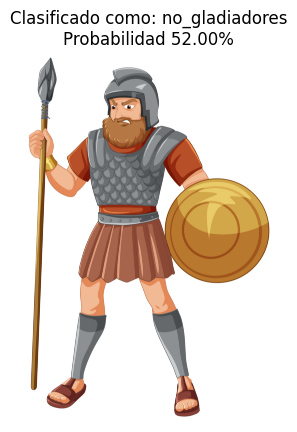

Clase predicha: no_gladiadores
Probabilidades: {'gladiadores': np.float64(0.48), 'no_gladiadores': np.float64(0.52)}

--- Intentando predecir para: no_gladiador.jpg ---

Procesando imagen para predicción: c:\Users\yoai\Documents\REPO_GLADIADORES_ML\REPO_GLADIADORES_ML\data\predict\no_gladiador.jpg
La imagen 'no_gladiador.jpg' se clasifica como: gladiadores
Probabilidades por clase: {'gladiadores': np.float64(0.79), 'no_gladiadores': np.float64(0.21)}


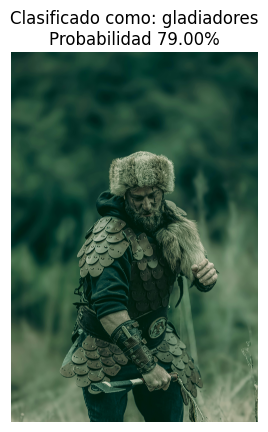

Clase predicha: gladiadores
Probabilidades: {'gladiadores': np.float64(0.79), 'no_gladiadores': np.float64(0.21)}


In [26]:
#PRUEBA CON NUEVAS IMÁGENES DE LA CARPETA 'predict' 

if loaded_model and loaded_scaler:
    # Asegúrate de que la carpeta PREDICT_DIR exista antes de intentar listar su contenido
    if not os.path.isdir(PREDICT_DIR):
        print(f"ERROR: La carpeta de predicción NO SE ENCONTRÓ: {PREDICT_DIR}")
        print("Asegúrate de que la estructura de carpetas sea 'REPO_GLADIADORES_ML/data/predict/'")
    else:
        # Rutas a las imágenes dentro de la carpeta 'predict'
        predict_gladiador_path = os.path.join(PREDICT_DIR, 'gladiador.jpg')
        predict_no_gladiador_path = os.path.join(PREDICT_DIR, 'no_gladiador.jpg')

        print(f"\n--- Intentando predecir para: {os.path.basename(predict_gladiador_path)} ---")
        predicted_class_gla, probabilities_gla = predict_new_image(loaded_model, loaded_scaler, predict_gladiador_path, class_labels=CLASS_LABELS)
        if predicted_class_gla: # Si no es None, la predicción fue exitosa
            print(f"Clase predicha: {predicted_class_gla}")
            print(f"Probabilidades: {probabilities_gla}")
        else:
            print(f"No se pudo predecir para {os.path.basename(predict_gladiador_path)}. Consulta los mensajes de error anteriores para más detalles.")

        print(f"\n--- Intentando predecir para: {os.path.basename(predict_no_gladiador_path)} ---")
        predicted_class_no_gla, probabilities_no_gla = predict_new_image(loaded_model, loaded_scaler, predict_no_gladiador_path, class_labels=CLASS_LABELS)
        if predicted_class_no_gla:
            print(f"Clase predicha: {predicted_class_no_gla}")
            print(f"Probabilidades: {probabilities_no_gla}")
        else:
            print(f"No se pudo predecir para {os.path.basename(predict_no_gladiador_path)}. Consulta los mensajes de error anteriores para más detalles.")
else:
    print("\nNo se pudo realizar la predicción porque el modelo o el scaler no se cargaron correctamente.")